<a href="https://colab.research.google.com/github/glasry/Audio_declipping/blob/main/run_example_random.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Requisites
import os
from os import walk
from google.colab import drive
import torch
import torchaudio
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
drive.mount('/content/gdrive/', force_remount=False)
!pip install import-ipynb
import import_ipynb
from sklearn.metrics import mean_squared_error
import numpy as np
import matplotlib.pyplot as plt

Mounted at /content/gdrive/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 39.1 MB/s eta 0:00:00


In [49]:
# Settings
project_folder = '/content/gdrive/My Drive/DLcourse_FinalProject' # CHANGE HERE TO YOUR PATH
model_folder = os.path.join(project_folder, 'Models')
data_folder = os.path.join(project_folder, 'Data','Clean')
demucs_path = os.path.join(model_folder, 'Demucs')
data_spade = os.path.join(project_folder, 'Data_SPADE')
fs = 16000
Threshold = 0.2
Twindow_demucs = 1
Twindow_rnn = 32e-3

number_samples_demucs = int(fs * Twindow_demucs)
number_samples_rnn = int(fs * Twindow_rnn)

In [3]:
# Load Utils function
os.chdir(project_folder)
import Utils

importing Jupyter notebook from Utils.ipynb
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 59.6/59.6 kB 1.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for julius: filename=julius-0.2.7-py3-none-any.whl size=21878 sha256=5f56d56bcb7881beb6b40e6eba45cf5e70154db0827cf8a89c14d1d35c2293d1
  Stored in directory: /root/.cache/pip/wheels/b9/b2/05/f883527ffcb7f2ead5438a2c23439aa0c881eaa9a4c80256f4
Successfully built julius


In [4]:
# Load track
list_filenames_clean = next(walk(data_folder), (None, None, []))[2]  # [] if no file
number_files = len(list_filenames_clean)
list_test = list_filenames_clean[int(number_files * 0.9) : int(number_files * 1)]
number_test_files = len(list_test)

In [5]:
# Load models
model_demucs = Utils.Demucs(
    audio_channels=1,
    context = 3,
    glu=True).to(device)
model_demucs.load_state_dict(torch.load(demucs_path, map_location=device))
number_padding = model_demucs.valid_length(number_samples_demucs) - number_samples_demucs

In [53]:
idx_random = np.random.randint(0, number_test_files)
file_name = list_test[idx_random:idx_random+1]
print(file_name)
track_path = os.path.join(data_folder, list_test[idx_random])
# file_name = list(['clean_example.flac'])
waveform, sample_rate = torchaudio.load(track_path)

['2277-149896-0021.flac']


In [54]:
all_data, idcs_windows, waveform_clipped = Utils.pre_proc(data_folder, file_name, Threshold, number_samples_demucs)
mse_clipped = mean_squared_error(waveform_clipped, waveform)
pred_demucs = Utils.Demucs_inference(model_demucs, all_data, number_padding, 1)
waveform_demucs = Utils.reconstruct_waveform(track_path, idcs_windows, pred_demucs, waveform_clipped, number_samples_demucs)
mse_demucs = mean_squared_error(waveform_demucs, waveform)

# A-SPADE
track_path = os.path.join(data_spade, list_test[idx_random])
waveform_spade, sample_rate = torchaudio.load(track_path)
mse_spade = mean_squared_error(waveform_spade, waveform)


In [55]:
# Play audio
print('Original audio file')
Utils.play_audio(waveform, sample_rate)
print('Clipped audio file: MSE=', mse_clipped)
Utils.play_audio(waveform_clipped, sample_rate)
print('DEMUCS declipped audio file: MSE=', mse_demucs)
Utils.play_audio(waveform_demucs, sample_rate)
print('A-SPADE declipped audio file: MSE=', mse_spade)
Utils.play_audio(waveform_spade, sample_rate)


Original audio file


Clipped audio file: MSE= 0.001099391


DEMUCS declipped audio file: MSE= 0.00015873359


A-SPADE declipped audio file: MSE= 0.0003864115


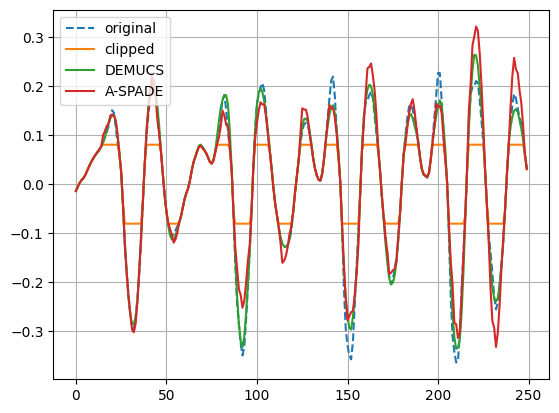

In [64]:
# print(waveform.numpy()[0])
number_samples = 250
idx_start = 7300
indices = range(idx_start,idx_start+number_samples)
plt.plot(waveform.numpy()[0][indices], '--', label='original')
plt.plot(waveform_clipped.numpy()[0][indices], label='clipped')
plt.plot(waveform_demucs[0][indices], label='DEMUCS')
plt.plot(waveform_spade[0][indices], label='A-SPADE')
plt.legend()
plt.grid()